In [390]:
import numpy as np
import pandas as pd

def calculate_cagr(cumulative_returns: pd.Series) -> float:
    """
    Calculate Compound Annual Growth Rate (CAGR).
    
    Parameters
    ----------
    cumulative_returns : pd.Series
        Cumulative return series, indexed by date, where the first value is 1.0.
    
    Returns
    -------
    float
        CAGR as a decimal (e.g. 0.12 for 12%).
    """
    n_years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    ending_value = cumulative_returns.iloc[-1]
    return ending_value ** (1 / n_years) - 1


def max_drawdown(cumulative_returns: pd.Series) -> float:
    """
    Calculate Maximum Drawdown.
    
    Parameters
    ----------
    cumulative_returns : pd.Series
        Cumulative return series, indexed by date.
    
    Returns
    -------
    float
        Maximum drawdown as a positive decimal (e.g. 0.2 for 20%).
    """
    peak = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - peak) / peak
    return abs(drawdowns.min())


def annual_volatility(returns: pd.Series, periods_per_year: int = 12) -> float:
    """
    Calculate annualized volatility of periodic returns.
    
    Parameters
    ----------
    returns : pd.Series
        Periodic returns (e.g. monthly returns).
    periods_per_year : int
        Number of periods per year (12 for monthly, 252 for daily).
    
    Returns
    -------
    float
        Annualized volatility.
    """
    return returns.std(ddof=1) * np.sqrt(periods_per_year)


def sharpe_ratio(returns: pd.Series, risk_free_rate: float = 0.05, periods_per_year: int = 12) -> float:
    """
    Calculate annualized Sharpe Ratio.
    
    Parameters
    ----------
    returns : pd.Series
        Periodic returns (e.g. monthly returns).
    risk_free_rate : float
        Annual risk-free rate (decimal). If periodic returns, convert to per-period: rf/periods_per_year.
    periods_per_year : int
        Number of periods per year.
    
    Returns
    -------
    float
        Annualized Sharpe ratio.
    """
    rf_per_period = risk_free_rate / periods_per_year
    excess_ret = returns - rf_per_period
    ann_ex_ret = excess_ret.mean() * periods_per_year
    ann_vol = annual_volatility(returns, periods_per_year)
    return ann_ex_ret / ann_vol


def sortino_ratio(returns: pd.Series, risk_free_rate: float = 0.05, periods_per_year: int = 12) -> float:
    """
    Calculate annualized Sortino Ratio (downside-risk-adjusted).
    
    Parameters
    ----------
    returns : pd.Series
        Periodic returns.
    risk_free_rate : float
        Annual risk-free rate.
    periods_per_year : int
        Periods per year.
    
    Returns
    -------
    float
        Annualized Sortino ratio.
    """
    rf_per_period = risk_free_rate / periods_per_year
    excess_ret = returns - rf_per_period
    downside = returns[returns < rf_per_period]
    downside_std = downside.std(ddof=1) if len(downside) > 1 else np.nan
    ann_ex_ret = excess_ret.mean() * periods_per_year
    ann_down_std = downside_std * np.sqrt(periods_per_year)
    return ann_ex_ret / ann_down_std


def calmar_ratio(cumulative_returns: pd.Series, risk_free_rate: float = 0.05) -> float:
    """
    Calculate Calmar Ratio = CAGR / Max Drawdown.
    
    Parameters
    ----------
    cumulative_returns : pd.Series
        Cumulative return series.
    risk_free_rate : float
        Annual risk-free rate (not used here but kept for signature consistency).
    
    Returns
    -------
    float
    """
    cagr = calculate_cagr(cumulative_returns)
    mdd = max_drawdown(cumulative_returns)
    return cagr / mdd if mdd != 0 else np.nan


In [391]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [392]:
no_of_stocks = 10

In [393]:

# 1) Load the Excel file (adjust path as needed)
df = pd.read_excel("nifty50_constituents.xlsx", sheet_name=0)

# 2) Extract the column names
cols = df.columns.tolist()

# 3) Parse each header to a date (skip any non‑date columns)
dates = []
for col in cols:
    try:
        # pandas will parse strings like '2024-09-30 00:00:00'
        dt = pd.to_datetime(col)
        dates.append(dt.date())      # or dt.strftime("%Y-%m-%d") for strings
    except (ValueError, TypeError):
        # skip columns that aren't parseable as dates
        continue

# 4) Now `dates` is a list of datetime.date objects in the same order as your columns
print(dates)


[datetime.date(2025, 3, 28), datetime.date(2024, 9, 30), datetime.date(2024, 3, 28), datetime.date(2023, 7, 13), datetime.date(2022, 9, 30), datetime.date(2022, 3, 31), datetime.date(2021, 3, 31), datetime.date(2020, 9, 25), datetime.date(2020, 7, 31), datetime.date(2020, 3, 19), datetime.date(2019, 9, 27), datetime.date(2019, 3, 29), datetime.date(2018, 9, 28), datetime.date(2018, 4, 2), datetime.date(2017, 9, 29), datetime.date(2017, 3, 31), datetime.date(2016, 4, 1)]


In [394]:
import pandas as pd
from datetime import date

# 1) Load your Excel and extract the rebalance dates (as before)
df_const = pd.read_excel("nifty50_constituents.xlsx", sheet_name=0)
cols = df_const.columns.tolist()

rebalance_dates = []
for col in cols:
    try:
        dt = pd.to_datetime(col)
        rebalance_dates.append(dt.date())
    except (ValueError, TypeError):
        continue

# 2) Determine the range for your new DataFrame
start_date = date(2016, 4, 1)
end_date   = max(rebalance_dates)   # last rebalance date

# 3) Build a daily date index from start to end
full_index = pd.date_range(start=start_date, end=end_date, freq="D")

# 4) Create an empty DataFrame with that index
df_all_dates = pd.DataFrame(index=full_index)

# 5) (Optional) Name the index
df_all_dates.index.name = "date"

print(df_all_dates.head())
print(df_all_dates.tail())


Empty DataFrame
Columns: []
Index: [2016-04-01 00:00:00, 2016-04-02 00:00:00, 2016-04-03 00:00:00, 2016-04-04 00:00:00, 2016-04-05 00:00:00]
Empty DataFrame
Columns: []
Index: [2025-03-24 00:00:00, 2025-03-25 00:00:00, 2025-03-26 00:00:00, 2025-03-27 00:00:00, 2025-03-28 00:00:00]


In [395]:
import pandas as pd
from datetime import date

# Load the Excel file
df_const = pd.read_excel("nifty50_constituents.xlsx", sheet_name=0)

# Extract date columns from headers
cols = df_const.columns.tolist()
rebalance_dates = []

for col in cols:
    try:
        dt = pd.to_datetime(col)
        rebalance_dates.append(dt.date())
    except (ValueError, TypeError):
        continue  # skip non-date columns

# Build the mapping: date → list of tickers
constituents_by_date = {}

for dt in rebalance_dates:
    # Convert date back to string format that matches column headers exactly
    col_str = pd.to_datetime(dt).strftime("%Y-%m-%d")
    
    # If Excel has full timestamp headers, we must match that format
    # Or use fuzzy matching if needed (e.g. pd.to_datetime(col).normalize())
    for col in df_const.columns:
        try:
            col_date = pd.to_datetime(col).date()
            if col_date == dt:
                tickers = df_const[col].dropna().tolist()
                constituents_by_date[dt] = tickers
                break
        except:
            continue

# ✅ Preview output
for d, tickers in constituents_by_date.items():
    print(f"{d}: {tickers[:5]}... ({len(tickers)} total)")


2025-03-28: ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2024-09-30: ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2024-03-28: ['UPL.NS', 'ADANIPORTS.NS', 'INFY.NS', 'ASIANPAINT.NS', 'BAJAJ-AUTO.NS']... (50 total)
2023-07-13: ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2022-09-30: ['SHREECEM.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2022-03-31: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2021-03-31: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2020-09-25: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2020-07-31: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2020-03-19: ['YESBANK.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT

In [396]:
# Reverse and sort the dictionary
constituents_by_date_reversed = {}

# Sort the dictionary by date in descending order (latest first)
for dt in sorted(constituents_by_date.keys(), reverse=False):
    sorted_tickers = sorted(constituents_by_date[dt])
    constituents_by_date_reversed[dt] = sorted_tickers

# ✅ Preview output
for d, tickers in constituents_by_date_reversed.items():
    print(f"{d}: {tickers[:5]}... ({len(tickers)} total)")


2016-04-01: ['ACC.NS', 'ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS']... (50 total)
2017-03-31: ['ACC.NS', 'ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS']... (50 total)
2017-09-29: ['ACC.NS', 'ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS']... (50 total)
2018-04-02: ['ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS', 'AXISBANK.NS']... (50 total)
2018-09-28: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2019-03-29: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2019-09-27: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2020-03-19: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2020-07-31: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2020-09-25: ['ADANIPORTS.NS',

In [397]:
all_dates = pd.date_range(start='2016-04-01', end='2025-01-01', freq='D')

# Step 2: Sort the dictionary keys
sorted_dict_dates = sorted(constituents_by_date_reversed.keys())

# Step 3: Initialize
data = []
last_known_data = None
j = 0  # index for sorted_dict_dates

# Step 4: Iterate through each date
# for date in all_dates:
    # Move forward in the sorted keys if current dict date <= current loop date
    # Inside the for-loop:
for date in all_dates:
    current_date = date.to_pydatetime().date()
    while j < len(sorted_dict_dates) and sorted_dict_dates[j] <= current_date:
        last_known_data = constituents_by_date_reversed[sorted_dict_dates[j]]
        j += 1
    data.append((date, last_known_data))


# Step 5: Create DataFrame
df = pd.DataFrame(data, columns=['Date', 'Constituents'])
df.set_index('Date', inplace=True)

# Optional: Show a sample
print(df.head(10))

                                                 Constituents
Date                                                         
2016-04-01  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-02  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-03  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-04  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-05  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-06  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-07  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-08  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-09  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-10  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...


In [398]:
# Resample to month-end and take the last known data for that month
df_month_end = df.resample('ME').last()
# print(len(df_month_end))
print(df_month_end.head())

                                                 Constituents
Date                                                         
2016-04-30  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-05-31  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-06-30  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-07-31  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-08-31  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...


In [399]:
# Get all unique stocks from the constituents dataframe
all_stocks = sorted(set(stock for lst in df_month_end['Constituents'] for stock in lst))

# Download adjusted daily price data (we'll later resample to monthly)
price_data = yf.download(all_stocks, start='2015-03-01', end='2025-01-01', interval='1d')['Close']


[*********************100%***********************]  67 of 67 completed

5 Failed downloads:
['YESBANK.NS']: ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'query2.finance.yahoo.com\', port=443): Max retries exceeded with url: /v8/finance/chart/YESBANK.NS?period1=1425148200&period2=1735669800&interval=1d&includePrePost=False&events=div%2Csplits%2CcapitalGains&crumb=hNTaopPGEgV (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000195843F1C10>: Failed to resolve \'query2.finance.yahoo.com\' ([Errno 11001] getaddrinfo failed)"))'))
['DRREDDY.NS']: ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'query2.finance.yahoo.com\', port=443): Max retries exceeded with url: /v8/finance/chart/DRREDDY.NS?period1=1425148200&period2=1735669800&interval=1d&includePrePost=False&events=div%2Csplits%2CcapitalGains&crumb=hNTaopPGEgV (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000195843C9690>: Failed to resolve \'query2.f

In [400]:
price_data

Ticker,ACC.NS,ADANIENT.NS,ADANIPORTS.NS,AMBUJACEM.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AUROPHARMA.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,...,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,VEDANTA.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-02,1537.768921,102.324722,313.489838,244.200409,1297.440063,766.756226,516.182312,626.728455,1600.532715,144.357101,...,12.076640,1106.897705,556.774536,390.514496,3245.360596,276.401306,NaN,117.251862,NaN,320.732056
2015-03-03,1533.843140,104.039955,319.373413,240.393494,1351.528198,778.551208,521.357971,611.097839,1633.905518,147.703964,...,12.097193,1151.100952,566.206482,393.733215,3236.740967,273.590546,NaN,118.654648,NaN,325.598053
2015-03-04,1504.925171,101.517525,315.055634,234.961090,1364.617065,777.158142,508.371460,593.047363,1637.454834,146.226959,...,11.925917,1138.661255,560.560852,389.473053,3188.057861,271.433502,NaN,116.369598,NaN,319.983521
2015-03-05,1481.807739,100.818443,316.052063,233.848969,1355.570190,774.464722,519.102600,596.967224,1634.792725,152.085190,...,11.758067,1118.114502,560.298157,384.124207,3071.767334,275.649628,NaN,117.834152,NaN,320.030243
2015-03-09,1448.179077,95.960953,308.412933,225.636261,1311.924438,754.729309,523.589478,572.577515,1628.002441,146.276688,...,11.519993,1097.526733,547.294067,378.396667,2952.923584,285.323822,NaN,116.475479,NaN,315.070770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,2079.899902,2372.449951,1182.199951,543.099976,7229.774414,2284.000000,1262.449951,1078.900024,8778.049805,1564.550049,...,140.380005,4113.920410,1704.900024,3353.399902,11390.349609,504.500000,NaN,299.351624,NaN,126.139999
2024-12-26,2087.649902,2400.250000,1243.949951,548.799988,7250.894531,2262.399902,1256.250000,1076.699951,8878.500000,1559.300049,...,140.360001,4103.683594,1698.699951,3323.050049,11460.650391,499.649994,NaN,299.106476,NaN,124.849998
2024-12-27,2065.600098,2409.949951,1230.699951,547.950012,7236.065430,2271.399902,1269.949951,1077.449951,8928.299805,1579.300049,...,138.910004,4099.500488,1711.650024,3309.199951,11406.549805,502.049988,NaN,303.077606,NaN,124.709999


In [401]:
# Extract adjusted close and convert to monthly close
monthly_prices = {}
for stock in all_stocks:
    try:
        monthly_prices[stock] = price_data[stock].resample('ME').last()
    except:
        pass

monthly_prices_df = pd.DataFrame(monthly_prices)


In [402]:
print(monthly_prices_df)

                 ACC.NS  ADANIENT.NS  ADANIPORTS.NS  AMBUJACEM.NS  \
Date                                                                
2015-03-31  1379.238281    88.696297     292.470337    218.407303   
2015-04-30  1265.342285    97.178932     301.343140    198.816498   
2015-05-31  1334.800537   101.805801     308.295044    203.265091   
2015-06-30  1274.918579    46.553738     293.111053    196.677765   
2015-07-31  1233.907593    45.990677     309.389771    198.731003   
...                 ...          ...            ...           ...   
2024-08-31  2329.149902  3019.350098    1481.900024    617.049988   
2024-09-30  2513.449951  3135.850098    1448.199951    632.549988   
2024-10-31  2320.399902  2947.250000    1375.949951    580.549988   
2024-11-30  2222.550049  2463.149902    1190.050049    531.500000   
2024-12-31  2052.500000  2528.649902    1231.099976    535.799988   

            APOLLOHOSP.NS  ASIANPAINT.NS  AUROPHARMA.NS  AXISBANK.NS  \
Date                          

In [403]:
roc_12m = (monthly_prices_df / monthly_prices_df.shift(12)) - 1
# roc_12m = (monthly_prices_df / monthly_prices_df.shift(6)) - 1



In [404]:
print(roc_12m)

              ACC.NS  ADANIENT.NS  ADANIPORTS.NS  AMBUJACEM.NS  APOLLOHOSP.NS  \
Date                                                                            
2015-03-31       NaN          NaN            NaN           NaN            NaN   
2015-04-30       NaN          NaN            NaN           NaN            NaN   
2015-05-31       NaN          NaN            NaN           NaN            NaN   
2015-06-30       NaN          NaN            NaN           NaN            NaN   
2015-07-31       NaN          NaN            NaN           NaN            NaN   
...              ...          ...            ...           ...            ...   
2024-08-31  0.164550     0.248555       0.878639      0.444708       0.442514   
2024-09-30  0.252639     0.299604       0.762605      0.493549       0.404646   
2024-10-31  0.232402     0.284919       0.760884      0.371899       0.460578   
2024-11-30  0.188394     0.044770       0.447796      0.213670       0.238131   
2024-12-31 -0.069143    -0.1

In [405]:
results = []

for date, row in tqdm(df_month_end.iterrows(), total=len(df_month_end)):
    constituents = row['Constituents']
    
    if date not in roc_12m.index:
        continue

    roc_values = roc_12m.loc[date, constituents].dropna()
    top_10 = roc_values.sort_values(ascending=False).head(no_of_stocks)

    for stock in top_10.index:
        results.append({
            'Date': date,
            'Stock': stock,
            'ROC_12M': top_10[stock]
        })


100%|██████████| 106/106 [00:00<00:00, 1786.98it/s]


In [406]:
top10_momentum_df = pd.DataFrame(results)


In [407]:
print(top10_momentum_df)

           Date          Stock   ROC_12M
0    2016-04-30        ZEEL.NS  0.338055
1    2016-04-30        BPCL.NS  0.337255
2    2016-04-30  BAJAJ-AUTO.NS  0.333429
3    2016-04-30  INDUSINDBK.NS  0.278560
4    2016-04-30  HEROMOTOCO.NS  0.276133
...         ...            ...       ...
1045 2024-12-31       TECHM.NS  0.377770
1046 2024-12-31     HCLTECH.NS  0.354663
1047 2024-12-31   POWERGRID.NS  0.353345
1048 2024-12-31        BPCL.NS  0.339477
1049 2024-12-31  BAJAJ-AUTO.NS  0.304955

[1050 rows x 3 columns]


In [408]:
returns = monthly_prices_df.pct_change()

portfolio_returns = []

for date in top10_momentum_df['Date'].unique():
    stocks = top10_momentum_df[top10_momentum_df['Date'] == date]['Stock'].tolist()
    next_month = date + pd.DateOffset(months=1)

    if next_month not in returns.index:
        continue
    
    # Equal-weighted average return
    monthly_return = returns.loc[next_month, stocks].mean()
    
    portfolio_returns.append({
        'Date': next_month,
        'Return': monthly_return
    })

backtest_df = pd.DataFrame(portfolio_returns).set_index('Date')


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17940\2694883313.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = monthly_prices_df.pct_change()


In [409]:
print(backtest_df)

              Return
Date                
2016-06-30  0.024210
2016-08-31  0.051821
2016-09-30 -0.006567
2016-11-30 -0.021955
2017-01-31  0.121597
2017-02-28 -0.004988
2017-04-30  0.048072
2017-06-30 -0.037426
2017-08-31  0.059246
2017-09-30 -0.012888
2017-11-30 -0.012125
2018-01-31  0.014937
2018-02-28 -0.040944
2018-04-30  0.070113
2018-06-30  0.006787
2018-08-31  0.036541
2018-09-30 -0.035300
2018-11-30  0.006447
2019-01-31  0.024483
2019-02-28  0.012724
2019-04-30  0.034191
2019-06-30  0.005668
2019-08-31 -0.011861
2019-09-30  0.091987
2019-11-30  0.008106
2020-01-31 -0.006001
2020-02-29 -0.020542
2020-04-30  0.101485
2020-06-30  0.038103
2020-08-31 -0.018765
2020-09-30  0.003544
2020-11-30  0.024944
2021-01-31 -0.008921
2021-02-28  0.060301
2021-04-30  0.084436
2021-06-30  0.015652
2021-08-31  0.039844
2021-09-30  0.019548
2021-11-30 -0.062745
2022-01-31 -0.029087
2022-02-28  0.000257
2022-04-30 -0.072554
2022-06-30 -0.039483
2022-08-31  0.069403
2022-09-30 -0.044537
2022-11-30 -0

In [410]:
nifty_data = yf.download("^NSEI", start="2016-06-30", end="2025-01-01", interval='1d', auto_adjust=True)
nifty_monthly = nifty_data['Close'].resample('ME').last()


[*********************100%***********************]  1 of 1 completed


In [411]:
nifty_returns = nifty_monthly.pct_change()
nifty_cumulative = (1 + nifty_returns).cumprod()


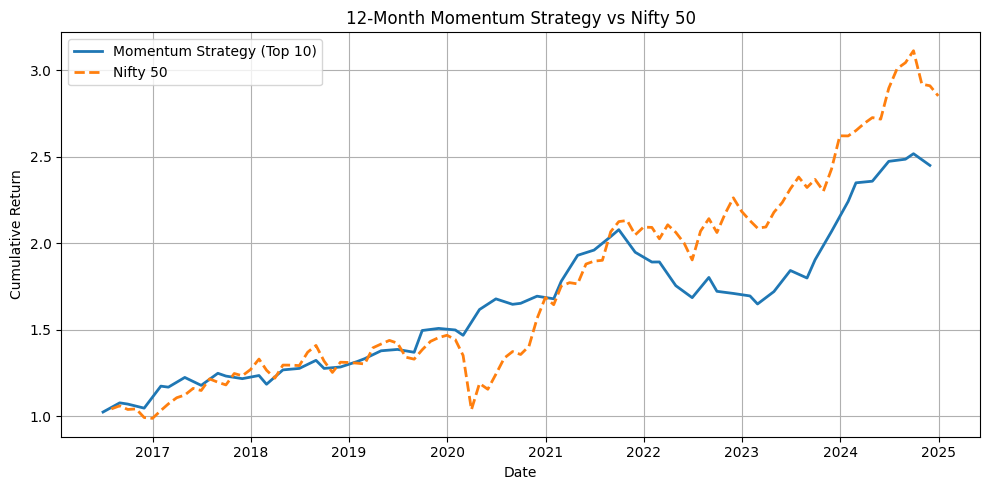

In [412]:
# # Cumulative returns
backtest_df['Cumulative'] = (1 + backtest_df['Return']).cumprod()

# # Plot


# backtest_df['Cumulative'].plot(figsize=(10, 5), title='12-Month Momentum Strategy (Top 10 Stocks)')
# plt.ylabel("Cumulative Return")
# plt.grid(True)
# plt.show()


# 2) Plot both series
plt.figure(figsize=(10, 5))
plt.plot(backtest_df.index, backtest_df['Cumulative'], label='Momentum Strategy (Top 10)', linewidth=2)
plt.plot(nifty_cumulative.index, nifty_cumulative,label='Nifty 50',linestyle='--', linewidth=2)

plt.title("12-Month Momentum Strategy vs Nifty 50")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [413]:
cum = backtest_df['Cumulative']
rets = backtest_df['Return']




In [414]:
cum_index = nifty_cumulative['^NSEI']
rets_index = nifty_returns['^NSEI']



In [415]:
vol_12m = returns.rolling(window=12).std()


In [416]:
results = []

for date, row in tqdm(df_month_end.iterrows(), total=len(df_month_end)):
    constituents = row['Constituents']
    
    if date not in roc_12m.index:
        continue

    roc_values = roc_12m.loc[date, constituents].dropna()
    vol_vals = vol_12m.loc[date, constituents].dropna()

    score = roc_values / vol_vals

    top_n = score.sort_values(ascending=False).head(no_of_stocks)
    # top_10 = roc_values.sort_values(ascending=False).head(no_of_stocks)

    for stock in top_10.index:
        results.append({
            'Date': date,
            'Stock': stock,
            'ROC_12M': top_10[stock]
        })


100%|██████████| 106/106 [00:00<00:00, 418.39it/s]


In [417]:
top10_volatility_df = pd.DataFrame(results)

In [418]:
returns = monthly_prices_df.pct_change()

portfolio_returns = []

for date in top10_volatility_df['Date'].unique():
    stocks = top10_volatility_df[top10_volatility_df['Date'] == date]['Stock'].tolist()
    next_month = date + pd.DateOffset(months=1)

    if next_month not in returns.index:
        continue
    
    # Equal-weighted average return
    monthly_return = returns.loc[next_month, stocks].mean()
    
    portfolio_returns.append({
        'Date': next_month,
        'Return': monthly_return
    })

vol_df = pd.DataFrame(portfolio_returns).set_index('Date')


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17940\1661814228.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = monthly_prices_df.pct_change()


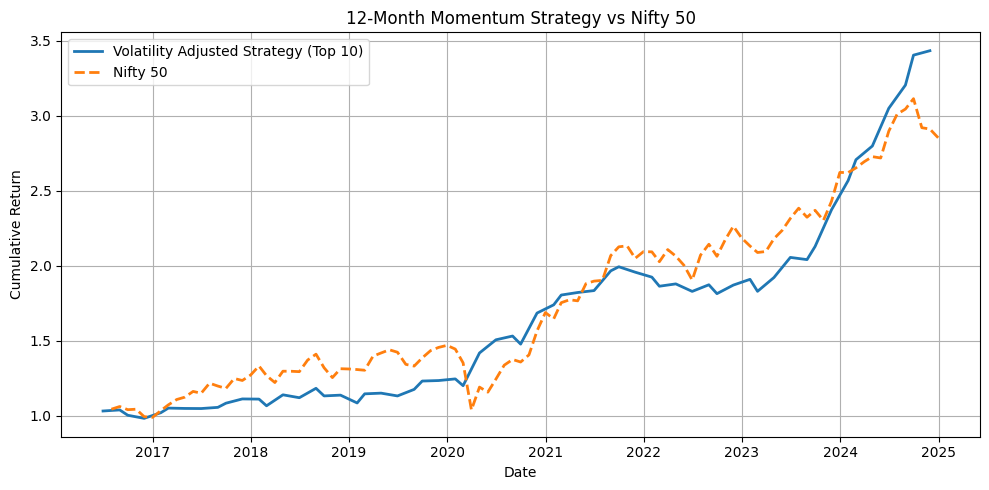

In [419]:
# # Cumulative returns
vol_df['Cumulative'] = (1 + vol_df['Return']).cumprod()

# # Plot


# backtest_df['Cumulative'].plot(figsize=(10, 5), title='12-Month Momentum Strategy (Top 10 Stocks)')
# plt.ylabel("Cumulative Return")
# plt.grid(True)
# plt.show()


# 2) Plot both series
plt.figure(figsize=(10, 5))
plt.plot(vol_df.index, vol_df['Cumulative'], label='Volatility Adjusted Strategy (Top 10)', linewidth=2)
plt.plot(nifty_cumulative.index, nifty_cumulative,label='Nifty 50',linestyle='--', linewidth=2)

plt.title("12-Month Momentum Strategy vs Nifty 50")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [420]:
cum_vol = vol_df['Cumulative']
rets_vol = vol_df['Return']




In [421]:
print("CAGR")
print("Index:", calculate_cagr(cum_index))
print("Price Momentum:", calculate_cagr(cum))
print("Volatility Adjusted:", calculate_cagr(cum_vol))

CAGR
Index: 0.13120385807726387
Price Momentum: 0.11236069234062684
Volatility Adjusted: 0.15783752992351996


In [422]:
print("Max Drawdown")
print("Index:", max_drawdown(cum_index))
print("Price Momentum:", max_drawdown(cum))
print("Volatility Adjusted:", max_drawdown(cum_vol))


Max Drawdown
Index: 0.29343919217321507
Price Momentum: 0.2067682464617776
Volatility Adjusted: 0.09007720200103027


In [423]:

print("Annual Volatility")
print("Price Momentum:", annual_volatility(rets))
print("Volatility Adjusted:", annual_volatility(rets_vol))
print("Index:", annual_volatility(rets_index))


Annual Volatility
Price Momentum: 0.14788082331278055
Volatility Adjusted: 0.15733433621498388
Index: 0.16314954022098482


In [424]:

print("Sharpe Ratio")
print("Volatility Adjusted:", sharpe_ratio(rets_vol))
print("Price Momentum:", sharpe_ratio(rets))
print("Index:", sharpe_ratio(rets_index))


Sharpe Ratio
Volatility Adjusted: 1.340658454890047
Price Momentum: 0.9544650820841661
Index: 0.5366842684930829


In [425]:

print("Sortino Ratio")
print("Price Momentum:", sortino_ratio(rets))
print("Volatility Adjusted:", sortino_ratio(rets_vol))
print("Index:", sortino_ratio(rets_index))


Sortino Ratio
Price Momentum: 2.1027430747134854
Volatility Adjusted: 3.714414117731259
Index: 0.6909522691555738


In [426]:

print("Calmar Ratio")
print("Price Momentum:", calmar_ratio(cum))
print("Volatility Adjusted:", calmar_ratio(cum_vol))
print("Index:", calmar_ratio(cum_index))

Calmar Ratio
Price Momentum: 0.5434136733436844
Volatility Adjusted: 1.752247254768356
Index: 0.44712452043493617
